In [1]:
display(HTML("<style>.rendered_html.text_cell_render {max-width:500px; }</style>"));
push!(LOAD_PATH, "../src");
push!(LOAD_PATH, ENV["probcomp"]*"/Gen-Distribution-Zoo/src");

include("../src/pose.jl")
include("src/csail_data.jl")
include("../src/cuda_raycaster_point_cloud_b.jl");

HTML{String}("<style>.rendered_html.text_cell_render {max-width:500px; }</style>")

Loading `../data/mit-csail.json` ...

	_zs 	Vector{Vector{Float64}}
	_zs_inf 	Vector{Vector{Float64}}
	_as 	Vector{Float64}
	_zmax 	Float64
	_ys 	Vector{Vector{Vector{Float64}}}
	_ys_inf 	Vector{Vector{Vector{Float64}}}
	_num_a 	Int64
	_xs 	Vector{Vector{Float64}}
	_hds 	Vector{Float64}
	_ps 	Vector{Pose}
	_dxs 	Vector{Vector{Float64}}
	_dhds 	Vector{Float64}
	_us 	Vector{Control}
	_T 	Int64


In [2]:
"""
    zs_ = cast_cu(ps_::CuArray, ys_::CuArray; fov=2π, zmax=Inf, cell_rad=0.01)

Computes depth measurements `zs_` with respect to a matrix of poses `ps_`
and a point cloud matrix `ys_` ...
"""
function cast_cu(ps_::CuArray, ys_::CuArray; fov=2π, zmax=Inf, cell_rad=0.05)
    zs_ = zmax*CUDA.ones(size(ps_, 1), 361)
    cast_cu!(zs_, ys_, ps_; fov=fov, cell_rad=cell_rad)
    return zs_
end;

# Sensor distribution - CUDA accelerated

## Sliding windows

In [139]:
#nbx --fname=src/sensor_distribution.jl
using CUDA
using Gen
using GenDistributionZoo: diagnormal


# Todo: handle wrap around smarter?
"""
    slw_kernel!(x, w::Int, y)

CUDA kernel to compute sliding windows...
Takes CuArrays of shape `(k,n)` and `(k,n,m=2w+1)` 
and fills the latter with ...
"""
function slw_kernel!(x, w::Int, y, wrap=false)
    
    m = 2*w + 1
    n = size(x,2)

    # Make sure the arrays are 
    # of the right shape
    @assert ndims(x)  == 2
    @assert ndims(y)  == ndims(x) + 1
    @assert size(x,1) == size(y,1)
    @assert size(x,2) == size(y,2)
    @assert size(y,3) == m
    
    # Thread id's
    ix = (blockIdx().x - 1) * blockDim().x + threadIdx().x
    iy = (blockIdx().y - 1) * blockDim().y + threadIdx().y
    iz = (blockIdx().z - 1) * blockDim().z + threadIdx().z
    sx = gridDim().x * blockDim().x
    sy = gridDim().y * blockDim().y
    sz = gridDim().z * blockDim().z
        
    for j_pose = ix:sx:size(y,1), j_obs = iy:sy:size(y,2), j_mix = iz:sz:size(y,3)
        # Transform mixture index in `1:m` 
        # to offsets in `-w:w`
        offset = j_mix-1-w
        
        j = j_obs + offset
        if wrap
            j = mod(j - 1 , n) + 1
            val = x[j_pose, j]
        else
            if 1 <= j <= n
                val = x[j_pose, j]
            else
                j = max(min(j,n),1)
                val = x[j_pose, j]
            end
        end
        
        # Fill entries of `y`
        @inbounds y[j_pose, j_obs, j_mix] = val
    end
    return
end

"""
```julia
    y = slw_cu!(x::CuArray, w::Int; blockdims=(8,8,4))
```
CUDA-accelerated function computing sliding windows. 
Takes a CuArray of shape `(k,n)` and returns a CuArray
of shape `(k,n,m)`, where `m = 2w+1`....
"""
function slw_cu!(x::CuArray, w::Int; blockdims=(8,8,4), wrap=false)
    
    k = size(x, 1)
    n = size(x, 2)
    m = 2*w+1
    
    y = CUDA.ones(k,n,m)
    
    griddims = cuda_grid((k,n,m), blockdims)
    CUDA.@sync begin
        @cuda threads=blockdims blocks=griddims slw_kernel!(x, w, y, wrap)
    end
    
    return y
end;

In [4]:
k = 10
n = 7
w = 2
m = 2*w + 1

x  = stack(fill(collect(1.0:n), k))
x_ = CuArray(x)

y_ = slw_cu!(x_, w, wrap=false)
y  = Array(y_);
y[1,:,:]

7×5 Matrix{Float32}:
 1.0  1.0  1.0  2.0  3.0
 1.0  1.0  2.0  3.0  4.0
 1.0  2.0  3.0  4.0  5.0
 2.0  3.0  4.0  5.0  6.0
 3.0  4.0  5.0  6.0  7.0
 4.0  5.0  6.0  7.0  7.0
 5.0  6.0  7.0  7.0  7.0

## Mixture Components

### 2D Mixture

In [5]:
#nbx
polar_inv_cu(z::CuArray, a::CuArray) = cat(z.*cos.(a), z.*sin.(a), dims=ndims(a)+1);

"""
    ys_tilde_ = get_ys_tilde_cu(zs_::CuArray, w::Int)    

Takes depth measurements and returns 
the point clouds for the gaussian mixtures ...
Returns array of shape `(k, n, m, 2)` ...
"""
function get_ys_tilde_cu(zs_::CuArray, as_::CuArray, w::Int; wrap=false)   

    zs_tilde_ = slw_cu!(zs_, w; blockdims=(8,8,4), wrap=wrap)
    as_tilde_ = slw_cu!(reshape(as_,1,:), w; blockdims=(8,8,4), wrap=wrap)
    ys_tilde_ = polar_inv_cu(zs_tilde_, as_tilde_)
    
    return ys_tilde_
end;

### 1D Mixture

In [173]:
"""
    log_p = gaussian_logpdf(x, mu, sig)

Benchmarks in `33 - CUDA Accelerated Gen Distributions` ...
"""
function gaussian_logpdf(x, mu, sig)
    d = (x .- mu).^2 ./ sig.^2
    log_p = - log.(sig) .- log(sqrt(2π)) .- 1/2 * d
    return log_p
end;

In [221]:
"""
    ys_tilde_1d_, ws_tilde_1d_ = get_1d_tilde_cu(zs_, as_, w, sig; wrap=false)
"""
function get_1d_tilde_cu(zs_, as_, w, sig; wrap=false)
    zs_tilde_    = slw_cu!(zs_, w; blockdims=(8,8,4), wrap=wrap)
    as_tilde_    = slw_cu!(reshape(as_,1,:), w; blockdims=(8,8,4), wrap=wrap)
    as_tilde_    = π/2 .- as_tilde_ .+ reshape(as_,1,:,1)
    ds_tilde_1d_ = zs_tilde_ .* cos.(as_tilde_)
    ys_tilde_1d_ = zs_tilde_ .* sin.(as_tilde_)
    ws_tilde_1d_ = gaussian_logpdf(ds_tilde_1d_, 0.0, sig)
    ws_tilde_1d_ = ws_tilde_1d_ .- logsumexp_cu(ws_tilde_1d_, dim=3)
    return ys_tilde_1d_, ws_tilde_1d_
end

get_1d_tilde_cu

## Likelihoods

### 1d Likelihood

In [222]:
"""
    log_p, pointwise = smc_1d_logpdf(ys_tilde_1d_, ws_tilde_1d_, sig, outlier, outlier_vol; return_pointwise=false)
"""
function smc_1d_logpdf(zs_, ys_tilde_1d_, ws_tilde_1d_, sig, outlier, outlier_vol; return_pointwise=false)

    log_p = gaussian_logpdf(zs_, ys_tilde_1d_, sig)
    log_p = logsumexp_cu(log_p .+ ws_tilde_1d_, dim=3)
    log_p = log.((1 .- outlier).*exp.(log_p) .+ outlier./outlier_vol)

    pointwise = nothing
    if return_pointwise
        pointwise = dropdims(log_p, dims=3)
    end

    log_p = sum(log_p, dims=2)
    log_p = dropdims(log_p, dims=(2,3))

    return log_p, pointwise
end;

(1, 361)
[98.91096822071384]


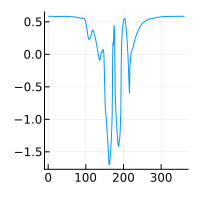

In [227]:
t = 1050
zs_ = CuArray(stack([_zs[t]]))
as_ = CuArray(_as);

w           = 10
sig         = 0.2
outlier     = 0.1
outlier_vol = 100.

ys_tilde_1d_, ws_tilde_1d_ = get_1d_tilde_cu(zs_, as_, w, sig, wrap=false);
log_p, pointwise = smc_1d_logpdf(zs_, ys_tilde_1d_, ws_tilde_1d_, sig, outlier, outlier_vol; return_pointwise=true);
println(size(pointwise))
ls = Array(pointwise)[1,:]

println(log_p)
# ----------------
plot(size=(200,200), legend=nothing)
plot!(ls)

### 2D Likelihood

In [171]:
#nbx
function logsumexp_cu(x; dim)
    c = maximum(x)
    return c .+ log.(sum(exp.(x .- c), dims=dim))
end


"""
    log_p = gaussian_logpdf(x, mu, sig)

Benchmarks in `33 - CUDA Accelerated Gen Distributions` ...
"""
function gaussian_logpdf(x, mu, sig)
    d = (x .- mu).^2 ./ sig.^2
    log_p = - log.(sig) .- log(sqrt(2π)) .- 1/2 * d
    return log_p
end;

In [172]:
for i=1:100
    x   = rand()
    mu  = rand()
    sig = rand()

    @assert isapprox(
        logpdf(normal, x, mu , sig), 
        gaussian_logpdf(x, mu, sig))
end

gaussian_logpdf(x,Inf,1)

-Inf

In [105]:
#nbx
"""
    log_p, ptw = sensor_smc_logpdf_cu(x, y, sig, outlier, outlier_vol=1.0; return_pointwise=false)

Evaluates the logpdf of an observation `x` (shape: `(n,2)`)
with respect to a number of different gaussian mixtures (e.g. from family 
of different poses) stacked along the first dim of `y` (shape: `(k,n,m,2)`).
Returns an array of log probabilities (shape: `(k,)`).
"""
function sensor_smc_logpdf_cu(x, y, sig, outlier, outlier_vol=1.0; return_pointwise=false)
    @assert size(x,1) == size(y,2)

    n = size(y,2)
    m = size(y,3)
    x = reshape(x, 1, n, 1, 2)
    
    # Line by line...
    # 1. Compute 1D Gaussians - (n,m,2)
    # 2. Convert to 2D gausians - (n,m)
    # 3. Convert to mixture of m 2D gausians (GM) - (n,)
    # 4. Convert to mixture of `GM` and `anywhere` (D) - (n,)
    # 5. Convert to Product of D's - ()
    log_p = gaussian_logpdf(x, y, sig)
    log_p = sum(log_p, dims=4)
    log_p = logsumexp_cu(log_p .- log(m), dim=3)
    log_p = log.((1 .- outlier).*exp.(log_p) .+ outlier./outlier_vol)
    
    pointwise = nothing
    if return_pointwise
        pointwise = dropdims(log_p, dims=(3,4))
    end

    log_p = sum(log_p, dims=2)
    log_p  = dropdims(log_p, dims=(2,3,4))

    return log_p, pointwise
end;

In [ ]:
# t = 1050
# zs_ = CuArray(stack([_zs[t]]))
# as_ = CuArray(_as)
# w           = 10


# ys_tilde_1d_, ws_tilde_1d_ = get_1d_tilde_cu(zs_, as_, w; wrap=false);


# sig         = 0.05
# outlier     = 0.1
# outlier_vol = 100.

# log_p, pointwise  = sensor_smc_logpdf_cu(x_, ys_tilde, sig, outlier, outlier_vol; return_pointwise=true)
# # size(pointwise)

# ls = Array(pointwise)[1,:]
# println(log_p)
# # ----------------
# plot(size=(200,200), legend=nothing)
# plot!(ls)

In [18]:
push!(LOAD_PATH, ENV["probcomp"]*"/Gen-Distribution-Zoo/src");
using GenDistributionZoo: diagnormal

In [ ]:
#nbx
struct SensorDistribution_CUDA <: Distribution{Vector{Vector{Float64}}} 
end

const sensordist_cu = SensorDistribution_CUDA()

function Gen.logpdf(::SensorDistribution_CUDA, x, y_tilde_::CuArray, sig, outlier, outlier_vol=1.0)
    
    n = size(y_tilde_, 1)
    m = size(y_tilde_, 2)
    
    x_        = CuArray(stack(x))
    ys_tilde_ = reshape(y_tilde_, 1, n, m, 2) 
    
    log_p, = sensor_smc_logpdf_cu(x_, ys_tilde_, sig, outlier, outlier_vol) # CuArray of length 1
    return CUDA.@allowscalar log_p[1]
end

function Gen.random(::SensorDistribution_CUDA, y_tilde_::CuArray, sig, outlier, outlier_vol=1.0)
    n = size(y_tilde_,1)
    m = size(y_tilde_,2)
    
    # Sample an observation point cloud `x`
    x = Vector{Float64}[]
    for i=1:n
        if bernoulli(outlier)
            # Todo: Change that to a uniform distribution, e.g. over a  
            #       circular area with radius `zmax`.
            x_i = [Inf;Inf]
        else
            j   = rand(1:m)
            y   = Array(y_tilde_[i,j,:])
            x_i = diagnormal(y, [sig;sig])

        end
        push!(x, x_i)
    end
    
    return x
end

(D::SensorDistribution_CUDA)(args...) = Gen.random(D, args...)
Gen.has_output_grad(::SensorDistribution_CUDA)    = false
Gen.has_argument_grads(::SensorDistribution_CUDA) = (false, false);